Table of the coefficients
        M=0       M=1        M=3            M=9
0 -0.022084  0.327398  -0.526030      -0.437008
1       NaN -0.698964  12.991664     118.561003
2       NaN       NaN -35.673020   -2500.976209
3       NaN       NaN  23.615036   22025.512284
4       NaN       NaN        NaN -102005.307007
5       NaN       NaN        NaN  274431.178670
6       NaN       NaN        NaN -444660.004200
7       NaN       NaN        NaN  427774.265728
8       NaN       NaN        NaN -224979.699289
9       NaN       NaN        NaN   49797.466303


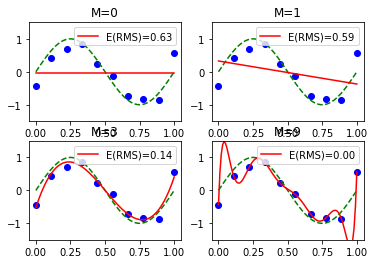

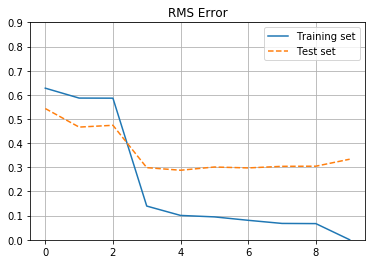

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

from numpy.random import normal

#------------#
# Parameters #
#------------#
N=10            # サンプルを取得する位置 x の個数
M=[0,1,3,9]     # 多項式の次数

# データセット {x_n,y_n} (n=1...N) を用意
def create_dataset(num):
    dataset = DataFrame(columns=['x','y'])
    for i in range(num):
        x = float(i)/float(num-1)
        y = np.sin(2*np.pi*x) + normal(scale=0.3)
        dataset = dataset.append(Series([x,y], index=['x','y']),
                                 ignore_index=True)
    return dataset

# 平方根平均二乗誤差（Root mean square error）を計算
def rms_error(dataset, f):
    err = 0.0
    for index, line in dataset.iterrows():
        x, y = line.x, line.y
        err += 0.5 * (y - f(x))**2
    return np.sqrt(2 * err / len(dataset))

# 最小二乗法で解を求める
def resolve(dataset, m):
    t = dataset.y
    phi = DataFrame()
    for i in range(0,m+1):
        p = dataset.x**i
        p.name="x**%d" % i
        phi = pd.concat([phi,p], axis=1)
    tmp = np.linalg.inv(np.dot(phi.T, phi))
    ws = np.dot(np.dot(tmp, phi.T), t)

    def f(x):
        y = 0
        for i, w in enumerate(ws):
            y += w * (x ** i)
        return y

    return (f, ws)

# Main
if __name__ == '__main__':
    train_set = create_dataset(N)
    test_set = create_dataset(N)
    df_ws = DataFrame()

    # 多項式近似の曲線を求めて表示
    fig = plt.figure()
    for c, m in enumerate(M):
        f, ws = resolve(train_set, m)
        df_ws = df_ws.append(Series(ws,name="M=%d" % m))

        subplot = fig.add_subplot(2,2,c+1)
        subplot.set_xlim(-0.05,1.05)
        subplot.set_ylim(-1.5,1.5)
        subplot.set_title("M=%d" % m)

        # トレーニングセットを表示
        subplot.scatter(train_set.x, train_set.y,
                        marker='o', color='blue', label=None)

        # 真の曲線を表示
        linex = np.linspace(0,1,101)
        liney = np.sin(2*np.pi*linex)
        subplot.plot(linex, liney, color='green', linestyle='--')

        # 多項式近似の曲線を表示
        linex = np.linspace(0,1,101)
        liney = f(linex)
        label = "E(RMS)=%.2f" % rms_error(train_set, f)
        subplot.plot(linex, liney, color='red', label=label)
        subplot.legend(loc=1)

    # 係数の値を表示
    print("Table of the coefficients")
    print(df_ws.transpose())
    fig.show()

    # トレーニングセットとテストセットでの誤差の変化を表示
    df = DataFrame(columns=['Training set','Test set'])
    for m in range(0,10):   # 多項式の次数
        f, ws = resolve(train_set, m)
        train_error = rms_error(train_set, f)
        test_error = rms_error(test_set, f)
        df = df.append(
                Series([train_error, test_error],
                    index=['Training set','Test set']),
                ignore_index=True)
    df.plot(title='RMS Error', style=['-','--'], grid=True, ylim=(0,0.9))
    plt.show()